https://www.datacamp.com/code-along/fine-tuning-your-own-llama-2-model

https://colab.research.google.com/drive/1GH8PW9-zAe4cXEZyOIE-T9uHXblIldAg?usp=sharing&pli=1&authuser=2#scrollTo=GCoXNvkB9_5d

In [ ]:
# install libraries; -q for 'quiet' to suppress info about installation
# sentence-transformers for embeddings
# faiss-gpu for similarity search
!pip install -q datasets transformers sentence_transformers faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 35.3 MB/s eta 0:00:00


In [ ]:
# access tokens stored in secrets
from google.colab import userdata
hf_token = userdata.get('colab_ft_maxLB')

In [ ]:
from datasets import load_dataset

# load dataset
# https://huggingface.co/docs/datasets/v2.19.0/en/package_reference/loading_methods#datasets.load_dataset
dataset = load_dataset("garage-bAInd/Open-Platypus")
dataset
# verify contents of DatasetDict below with columns in below link
# https://huggingface.co/datasets/garage-bAInd/Open-Platypus/viewer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/24926 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [ ]:
# read as a pandas dataframe
dataset['train'].to_pandas()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
24921,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
24922,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
24923,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
24924,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


##### EDA of dataset

In [ ]:
from transformers import AutoTokenizer # for tokenization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [ ]:
# tokenize each row and count number of tokens
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example['output'])) for example in dataset['train']]
combined_token_counts = [instruction+output for instruction, output in zip(instruction_token_counts, output_token_counts)]

In [ ]:
# sanity check
print(type(instruction_token_counts), len(instruction_token_counts), len(combined_token_counts))
instruction_token_counts[0], combined_token_counts[0]

<class 'list'> 24926 24926


(85, 308)

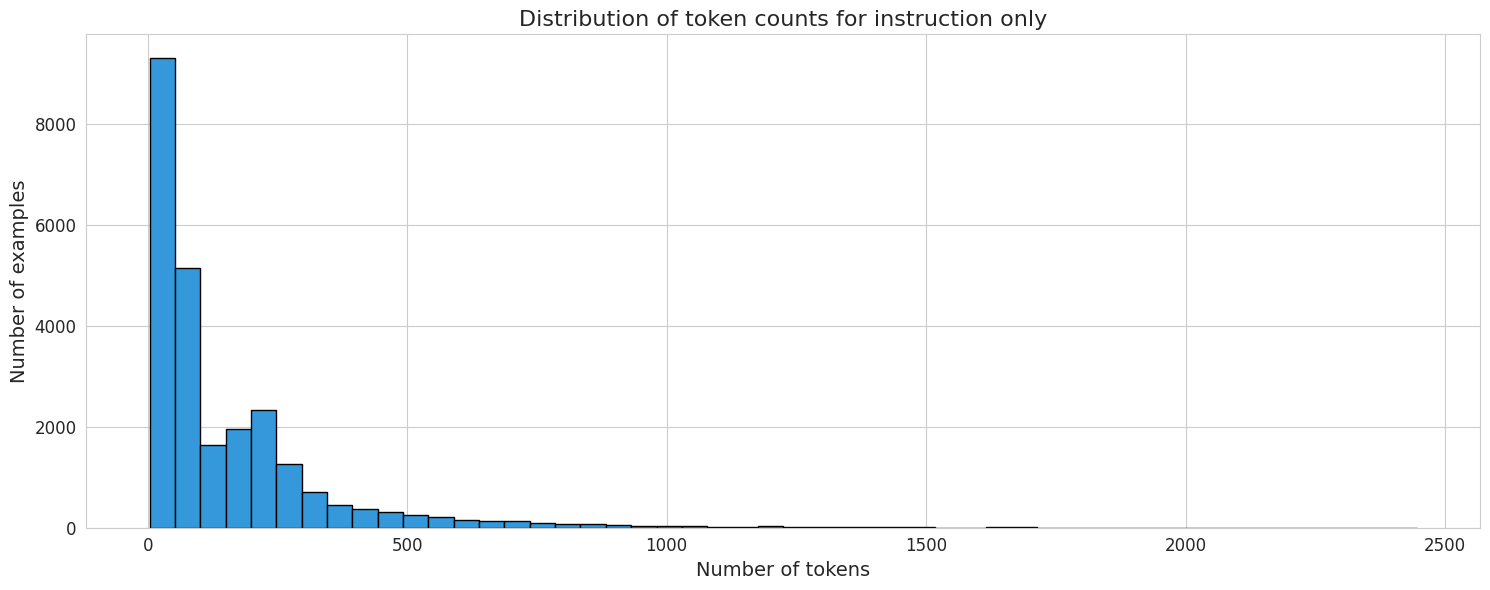

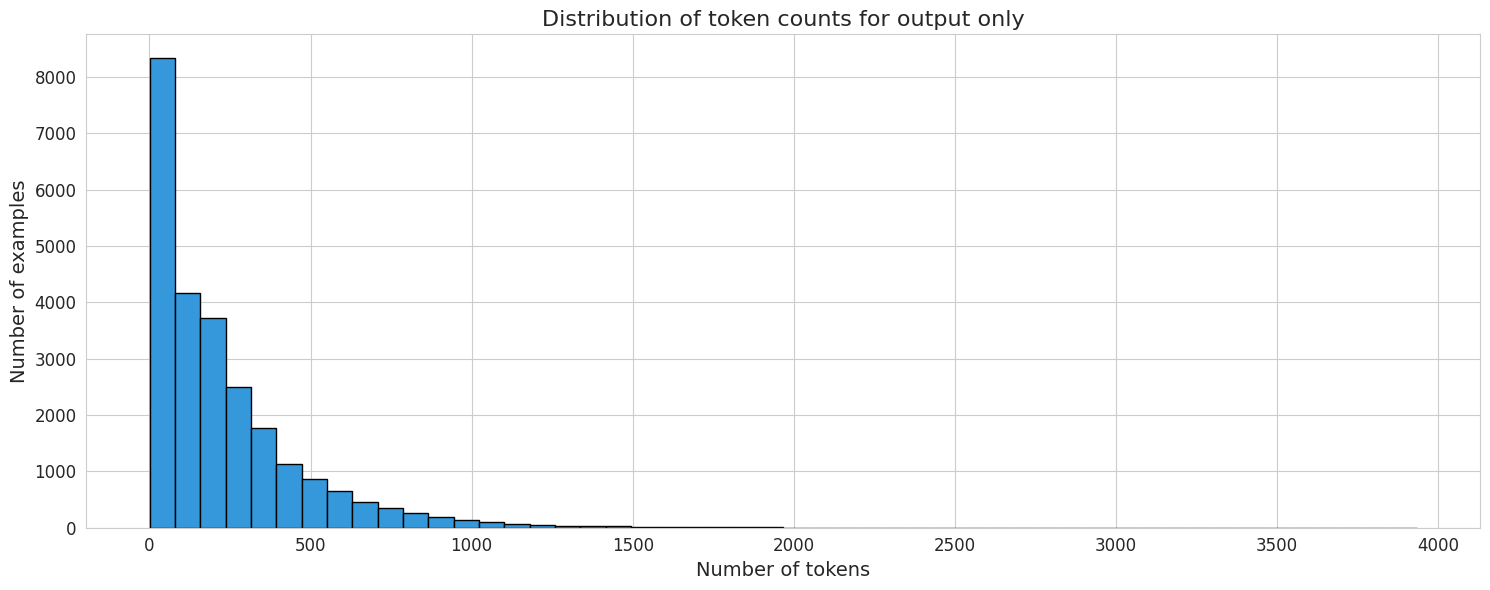

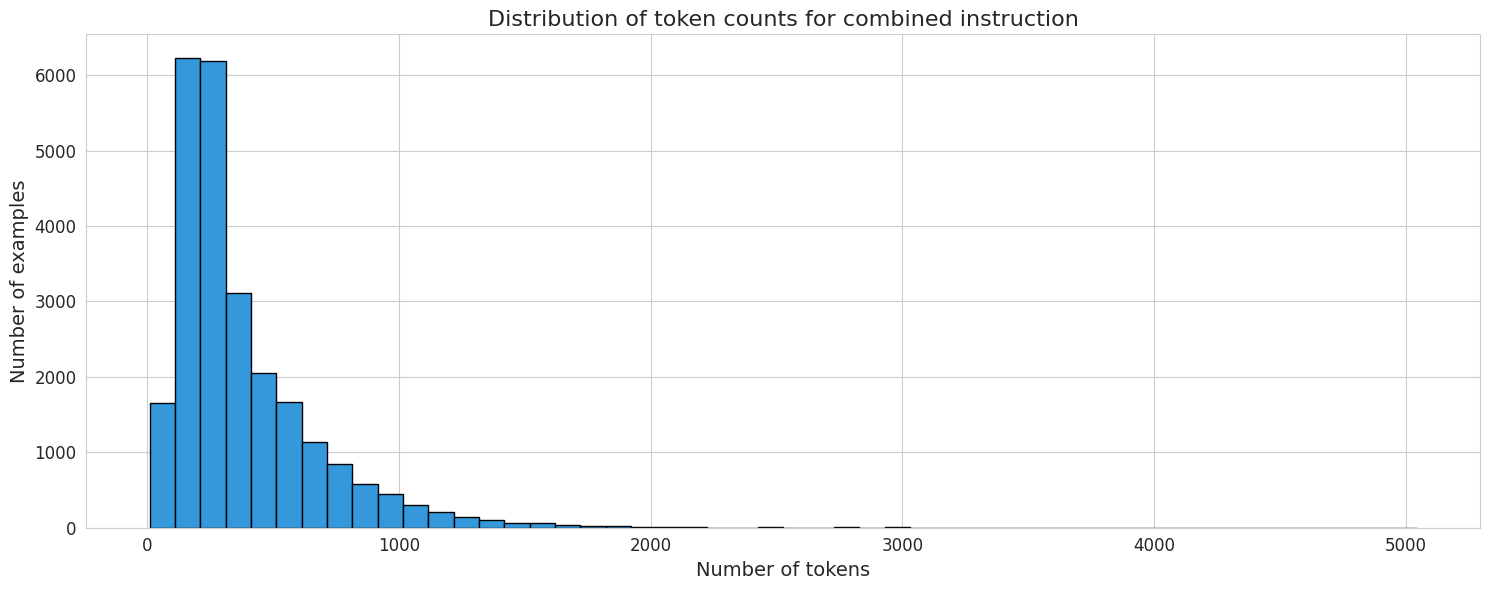

In [ ]:
# helper functions to plot distributions
def plot_distribution(token_counts, title):
  sns.set_style("whitegrid")
  plt.figure(figsize=(15,6))
  plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
  plt.title(title, fontsize=16)
  plt.xlabel("Number of tokens", fontsize=14)
  plt.ylabel("Number of examples", fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

# plot distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction")

##### Filter out rows with more than 2048 tokens

* Max size of Llama2 = 4096; hence can keep larger length

Number of valid rows: 24895
Removing 31 rows since their token count is more than 2048 tokens.


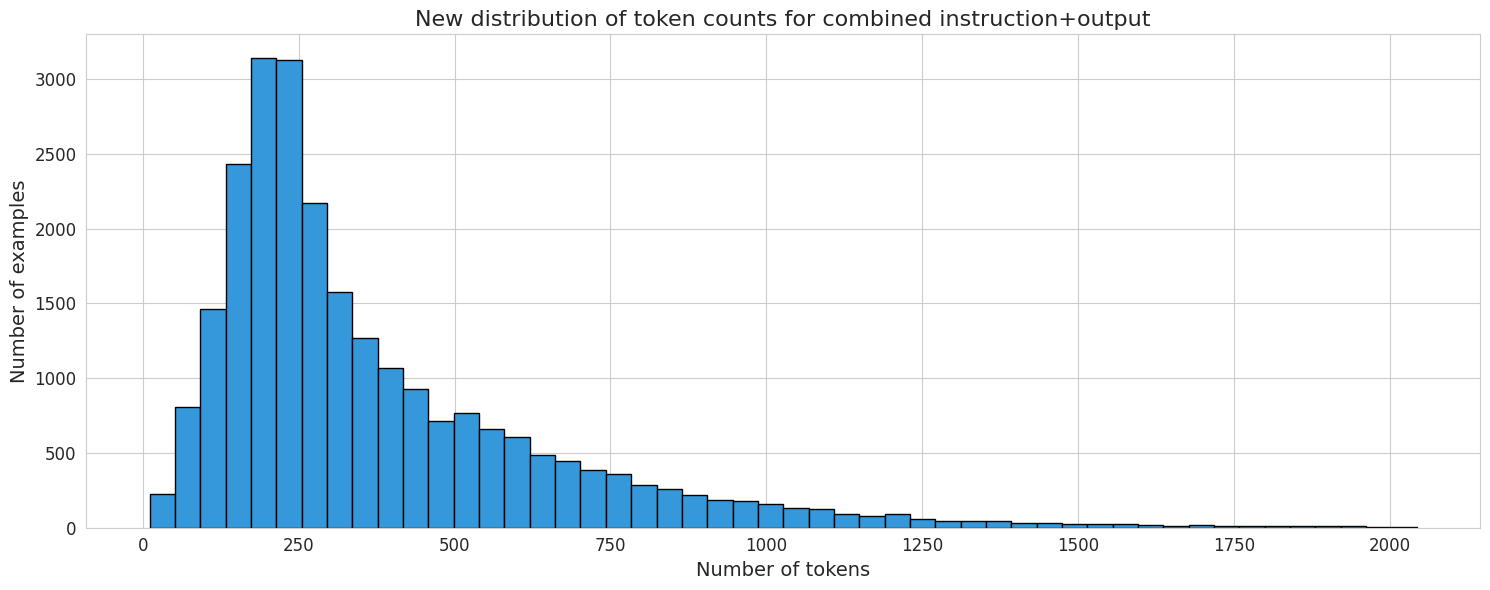

In [ ]:
# filter out rows with more than 2048 tokens combined
# combined since we want to pass all fields as context into model

# use enumerate to get index of counts and filter on them
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(f"Number of valid rows: {len(valid_indices)}")
print(f"Removing {len(dataset['train']) - len(valid_indices)} rows since their token count is more than 2048 tokens.")

# filter out invalid rows and retain only valid rows
dataset['train'] = dataset['train'].select(valid_indices)

# get token counts for valid rows
token_counts = [combined_token_counts[i] for i in valid_indices]

# plot distribution of valid token_counts
plot_distribution(token_counts, "New distribution of token counts for combined instruction+output")

##### Near de-duplication using embeddings

* check out MTEB leaderboard for choosing embedding model

https://huggingface.co/spaces/mteb/leaderboard

**Note on FAISS (From ChatGPT)**

* FAISS - Facebook AI Similarity Search
* for efficient similarity search and clustering of dense vectors
* Features
  * Optimised for fast and memory - efficient similarity search especially in high-dimensional vector spaces.
  * Employs techniques such as indexing, quantization, GPU acceleration to speed up
  * Large scale indexing - can handle Mns or Bns of vectors; suitable for large data collections such as image retrieval, recommendation systems, NLP, etc.
  * GPU acceleration: Has GPU accelerated implementations of similarity search algorithms
  * Various distance metrics: Supports various distance metrics for similarity search - Euclidean distance, cosine similarity, inner product similarity
  * Integrated with TF & PF to enable easier pipeline creation

**IndexFlatIP**

* `IndexFlatIP` - Index Flat with Inner Product
* An index data structure that organises a set of vectors for efficient similarity search.
* Flat structure - Does not build a tree or hierarchical structure
* Efficient search - Faster due to above reasons

**Compairson with Cosine Similarity**

Inner product similarity and cosine similarity are both measures of similarity between vectors, but they differ in the way they are computed and the properties they emphasize.

1. Definition:

Inner Product Similarity: The inner product similarity between two vectors
`a and 𝑏` is defined as the dot product of the two vectors:
`𝑎 ⋅ 𝑏`.

It measures the alignment or projection of one vector onto another.
Cosine Similarity: Cosine similarity measures the cosine of the angle between two vectors. It is calculated as the dot product of the two vectors divided by the product of their magnitudes:
`
𝑎.𝑏
/
∥a∥∥b∥
​`
 .
2. Range:

* Inner Product Similarity: The range of inner product similarity is unbounded, meaning it can take any real value from negative infinity to positive infinity.
* Cosine Similarity: Cosine similarity values range from -1 to 1, where -1 indicates completely opposite directions, 1 indicates identical directions, and 0 indicates orthogonality.

3. Normalization:

* Inner Product Similarity: Inner product similarity is not normalized by default. It directly reflects the magnitude of the vectors involved.
* Cosine Similarity: Cosine similarity is inherently normalized. It only depends on the direction of the vectors, not their magnitudes. This makes it useful for comparing the similarity of documents or vectors of different lengths.

4. Invariance:

* Inner Product Similarity: Inner product similarity is not invariant to changes in the magnitudes of the vectors. Scaling one vector can affect the similarity measure.
* Cosine Similarity: Cosine similarity is invariant to scaling of the vectors. Multiplying one or both vectors by a constant does not change their cosine similarity.


In summary, while both inner product similarity and cosine similarity measure the similarity between vectors, they differ in their mathematical definitions, range, normalization properties, and sensitivity to vector magnitudes. Cosine similarity is often preferred in text processing and information retrieval tasks because of its normalization properties and invariance to vector lengths. Inner product similarity, on the other hand, may be useful in certain contexts where the raw alignment or projection of vectors is of interest.

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

In [ ]:
def deduplicate_dataset(dataset:Dataset, model:str, threshold:float):
  # function to deduplicate similar queries

  # SentenceTransformer library to calculate embeddings
  sentence_model = SentenceTransformer(model)
  # get all outputs since we don't want similar outputs
  outputs = [example["output"] for example in dataset['train']]

  print("Converting text to embeddings:")
  embeddings = sentence_model.encode(outputs, show_progress_bar=True)
  dimension = embeddings.shape[1]

  """
  IndexFlatIP - Indexing method provided by FAISS library

  """
  index = faiss.IndexFlatIP(dimension)
  normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
  index.add(normalized_embeddings)

  print("Filtering out near-duplicates:")
  D, I = index.search(normalized_embeddings, k=2)
  to_keep = []

  for i in tqdm(range(len(embeddings)), desc="Filtering"):
    # if the second closest vector ([D,I]) has cosine similarity above threshold
    if D[i,1] >= threshold:
      # check if either current item or its nearest neighbor is already in to_keep list
      nearest_neighbor = I[i,1]
      if i not in to_keep and nearest_neighbor not in to_keep:
        # if not then append current item to the list
        to_keep.append(i)
    else:
      # if similarity is below threshold, always keep the current item
      to_keep.append(i)

  dataset = dataset['train'].select(to_keep)
  return DatasetDict({"train":dataset})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24895
    })
})

In [ ]:
deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Converting text to embeddings:


Batches:   0%|          | 0/778 [00:00<?, ?it/s]

Filtering out near-duplicates:


Filtering:   0%|          | 0/24895 [00:00<?, ?it/s]

In [ ]:
print(f"Number of samples in the original dataset: {len(dataset['train'])}")
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}")
print(f"Number of samples that were removed: {len(dataset['train']) - len(deduped_dataset['train'])}")

Number of samples in the original dataset: 24895
Number of samples in the deduped dataset: 18161
Number of samples that were removed: 6734


##### Top K Sampling

Only keep top K samples with most tokens

In [ ]:
# Get the top k rows with the most tokens
def get_top_k_rows(dataset, token_counts, k):
    # Sort by descending token count and get top k indices
    sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)
    top_k_indices = sorted_indices[:k]

    # Extract top k rows
    top_k_data = {
        "instruction": [dataset['train'][i]["instruction"] for i in top_k_indices],
        "output": [dataset['train'][i]["output"] for i in top_k_indices]
    }

    return Dataset.from_dict(top_k_data)

# Get token counts
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in deduped_dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in deduped_dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

k = 1000  # You can adjust this value as needed
top_k_dataset = get_top_k_rows(deduped_dataset, combined_token_counts, k)

# Save these rows in a Dataset object with a 'train' split
dataset = DatasetDict({"train": top_k_dataset})

In [ ]:
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [ ]:
# inspect as pandas dataframe
dataset['train'].to_pandas()

,instruction,output
0,Let's come up with a rich and complex alien wo...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"Let\n$$p(x,y) = a_0 + a_1x + a_2y + a_3x^2 + a...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"Given the code below, refactor it, add comment...",Here is the refactored and commented version:\...
3,Find the area of the region described by $x \g...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,Let $P$ be the plane passing through the origi...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,Hello. My name is Mike. I have a message left ...,"Hello Mike, it's nice to meet you. As an AI la..."
996,"Given a prime $p$ and an integer $a$, we say t...","To find the primitive roots $\pmod 7$, I need ..."
997,Let $f$ be defined by \[f(x) = \left\{\n\begi...,The number $f^{-1}(-3)$ is the value of $x$ su...
998,"BEGININPUT\nBEGINCONTEXT\ndate: August 5, 2021...",Dr. Eleanor Thompson's study found that partic...


##### Chat Templates

https://huggingface.co/blog/chat-templates

https://ogre51.medium.com/instruction-fine-tuning-of-llms-a-comprehensive-guide-e2f197e19c36

https://wandb.ai/capecape/alpaca_ft/reports/How-to-fine-tune-an-LLM-Part-1-Preparing-a-Dataset-for-Instruction-Tuning--Vmlldzo1NTcxNzE2

https://huggingface.co/blog/chat-templates


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output'],
        num_rows: 1000
    })
})

In [ ]:
def chat_template(example):
  example["instruction"] = f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
  return example

In [ ]:
dataset = dataset.map(chat_template)
dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output'],
        num_rows: 1000
    })
})

In [ ]:
dataset['train'][0]

{'instruction': '### Instruction:\nLet\'s come up with a rich and complex alien world setting suitable for stories, pseudo-documentaries, or roleplaying games such as DnD. This can be an involved process, so I\'d like you to just cover the basics first. We can refine the details further later.\n\nI\'d like a planet with a variety of biomes, inhabited by many creatures, much like Earth, but life on this world took its own path, with different plants and animals (and perhaps a different distinction than "plant" vs. "animal" to begin with)\n\nThere should be at least one sentient species represented in a wide variety of cultures and societies. They should have complex interactions with each other, and other species on the planet, and resulting from that, their own needs and wants and fears which ought to be relatable in context but may at the same time be strange, unusual, and, well, alien to humans.\n\nBut let\'s start at the beginning: Can you give a few broad, interesting biomes and ho

In [ ]:
dataset['train'].to_pandas()

,instruction,output
0,### Instruction:\nLet's come up with a rich an...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"### Instruction:\nLet\n$$p(x,y) = a_0 + a_1x +...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"### Instruction:\nGiven the code below, refact...",Here is the refactored and commented version:\...
3,### Instruction:\nFind the area of the region ...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,### Instruction:\nLet $P$ be the plane passing...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,### Instruction:\nHello. My name is Mike. I ha...,"Hello Mike, it's nice to meet you. As an AI la..."
996,### Instruction:\nGiven a prime $p$ and an int...,"To find the primitive roots $\pmod 7$, I need ..."
997,### Instruction:\nLet $f$ be defined by \[f(x...,The number $f^{-1}(-3)$ is the value of $x$ su...
998,### Instruction:\nBEGININPUT\nBEGINCONTEXT\nda...,Dr. Eleanor Thompson's study found that partic...


In [ ]:
# Optional: push to Hugging Face Hub
dataset.push_to_hub("mini-platypus", token=hf_token)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/gurdeep101/mini-platypus/commit/a77f0a6d02f971bfad2cdaa3fb4641a071a7aa0c', commit_message='Upload dataset', commit_description='', oid='a77f0a6d02f971bfad2cdaa3fb4641a071a7aa0c', pr_url=None, pr_revision=None, pr_num=None)

https://colab.research.google.com/drive/1p68M5E5fZ7kSa7nA-e-20489nuFSXVp2?usp=sharing&pli=1&authuser=1

https://huggingface.co/blog/chat-templates